# Employee Attrition - Logistic, Ridge, and Lasso Regression

## Author: Yuanying Li



### Part 1 - Use logistic regression to predict when people are going to leave a company 
### Part 2 - Use logistic regression to predict when customers are going to transact 
### Part 3 - Use regularization to predict salaries for a sports player


#Import necessary packages#

In [ ]:
import numpy as np
import random
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from pylab import rcParams
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing
import seaborn as sbn
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt




rcParams['figure.figsize'] = (23, 8)
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

#Part 1 - Use logistic regression to predict when people are going to leave a company 
## 1.1 Data Acquisition & Rudimentary Analysis#



In [ ]:
#Read data from Google Sheet
df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRBAjmMRXtstH8lFW_38qS6T5uN04b5sSCSLVz_wJl1V9YLnXcgHBs2-vxkmQixxTkQZC2fYxI9vVTb/pub?output=csv')
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (11249, 10)


In [ ]:
df.head()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,0,ADMIN,SMALL
3,0.60,0.65,4,160,2,0,0,0,IS,SMALL
4,0.85,0.92,4,151,3,1,0,0,IS,MEDIUM


In [ ]:
# Columns datatypes and missign values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11249 entries, 0 to 11248
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_satisfaction    11249 non-null  float64
 1   last_performance_rating  11249 non-null  float64
 2   workload                 11249 non-null  int64  
 3   avg_montly_hours         11249 non-null  int64  
 4   tenure_years             11249 non-null  int64  
 5   ergo_issues              11249 non-null  int64  
 6   attrit                   11249 non-null  int64  
 7   promo_in_last_5_years    11249 non-null  int64  
 8   dept                     11249 non-null  object 
 9   salary                   11249 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 879.0+ KB


### **observation**
1.The data provided has no missing values.we do not have to do any imputation

2.The dataset contains several numerical and categorical columns providing various information on employee's personal and employment details, so we need to preprocessing data at first. For example, here are two categorical variables in this dataset: 'dept' and 'salary'. Labels are changed to numeric so that these variables can be used while fitting the model.





In [ ]:
df.describe()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years
count,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000
mean,0.612957,0.716225,3.799716,201.176727,3.499600,0.144991,0.239577,0.021869
std,0.248235,0.171378,1.232190,50.058105,1.469892,0.352107,0.426844,0.146261
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


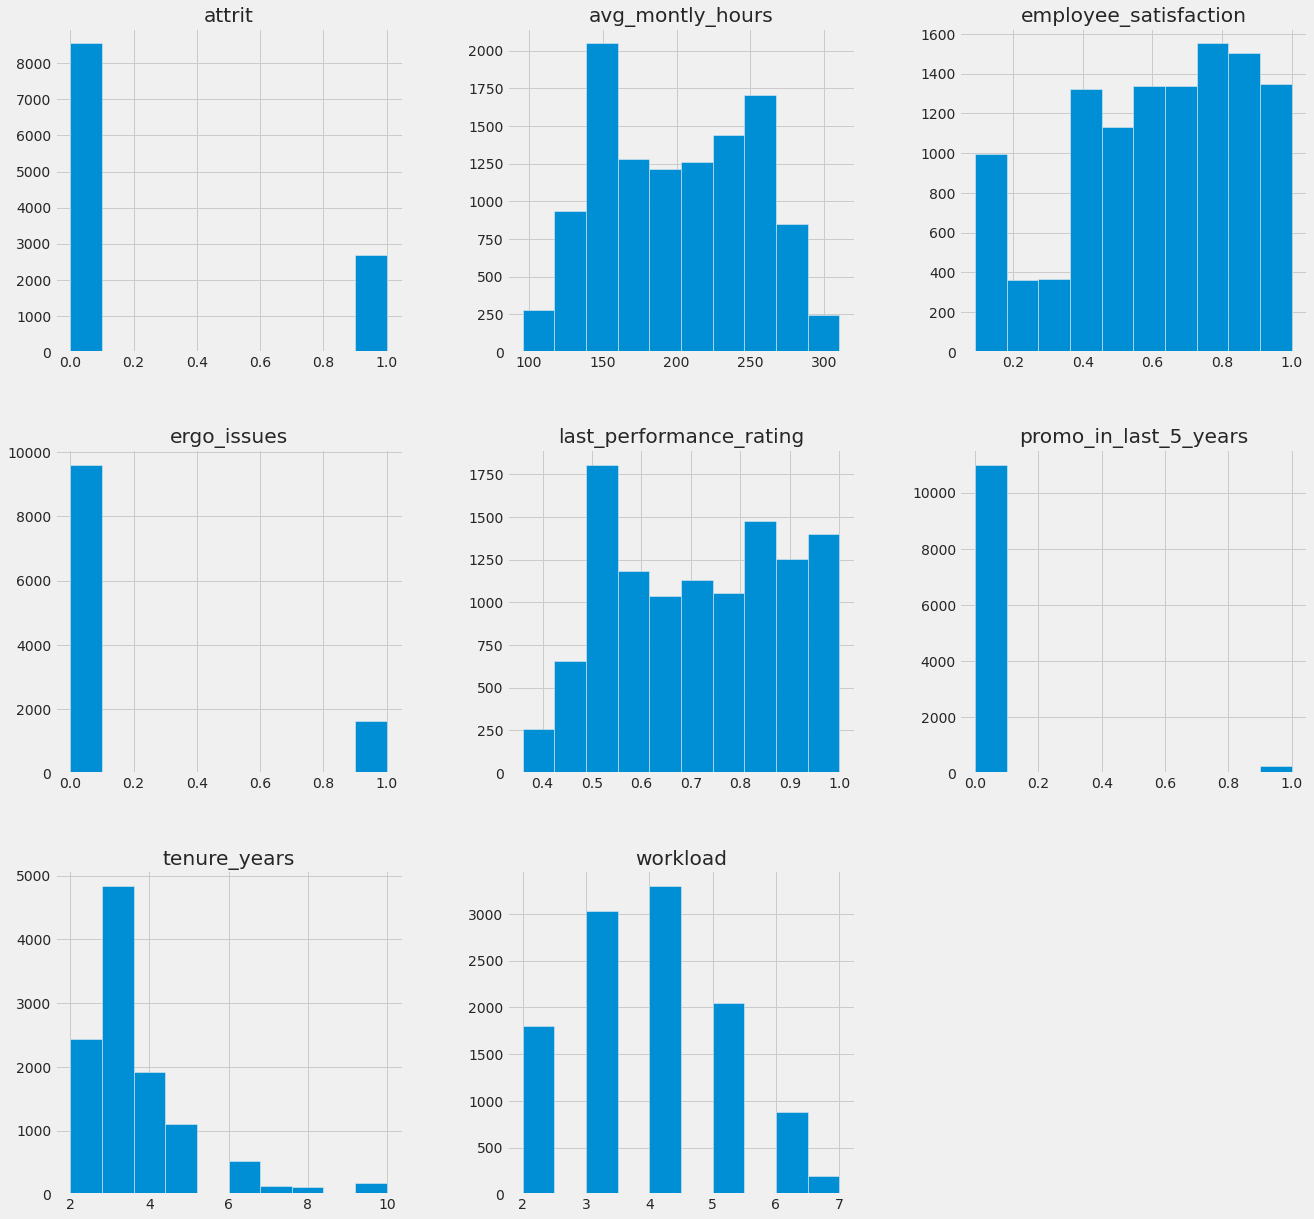

In [ ]:
df.hist(figsize=(20,20))
plt.show()

A few observations can be made based on the information and histograms for numerical features. There are few people are promoted in last 5 years.

## 1.2 Feature distribution by target attribute

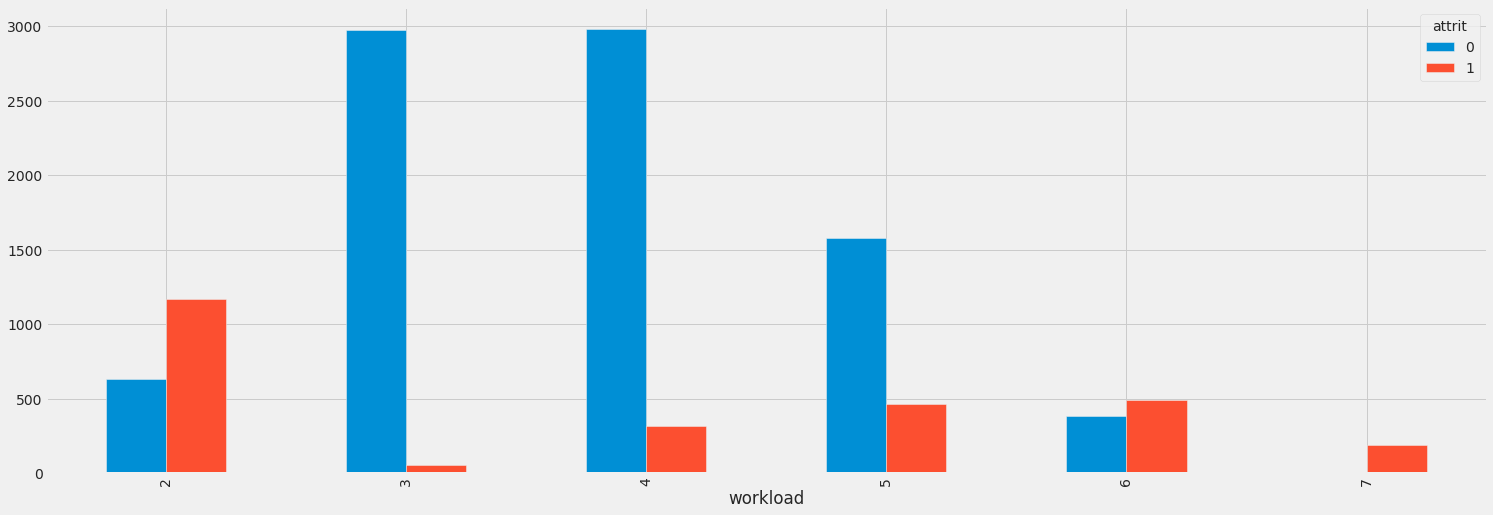

<Figure size 72x72 with 0 Axes>

In [ ]:
#Observe the relation between the number of attrition and the workload
pd.crosstab(df.workload, df.attrit).plot(kind='bar')
fig= plt.figure(figsize=(1,1))
plt.show()

attrit       0     1
workload            
2          632  1169
3         2973    58
4         2983   318
5         1580   465
6          386   492
7            0   193
workload
2    1801
3    3031
4    3301
5    2045
6     878
7     193
dtype: int64


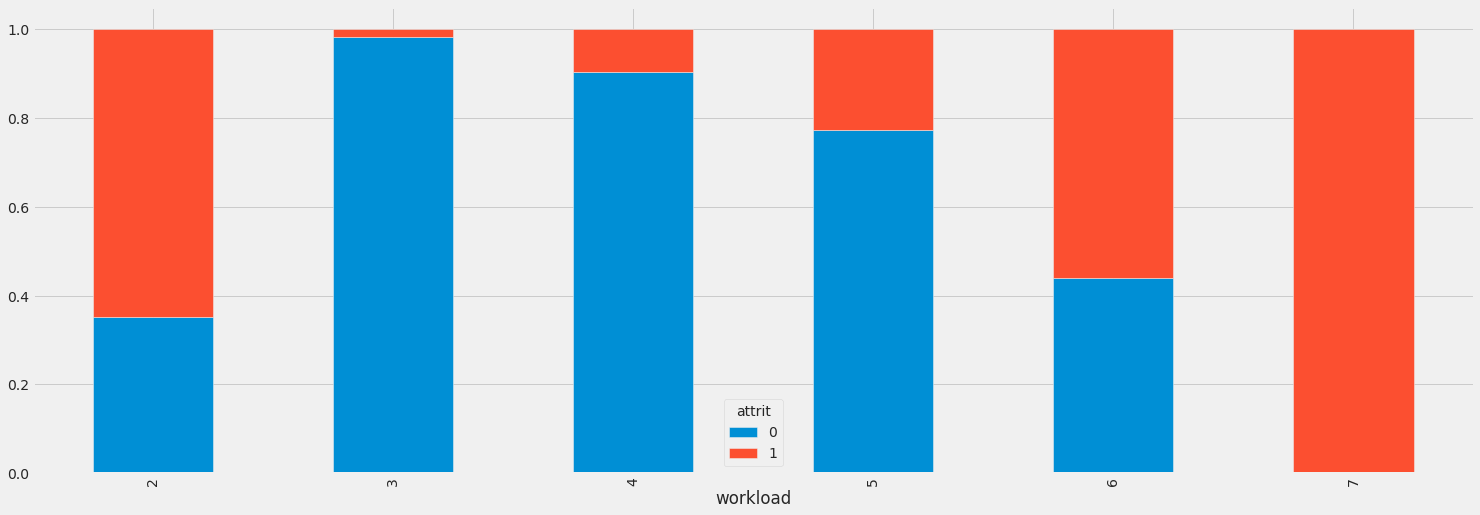

In [ ]:
q = pd.crosstab(df.workload, df.attrit)
print(q)
print(q.sum(1))
q.div(q.sum(1), axis = 0).plot(kind='bar', stacked = True)
plt.show()

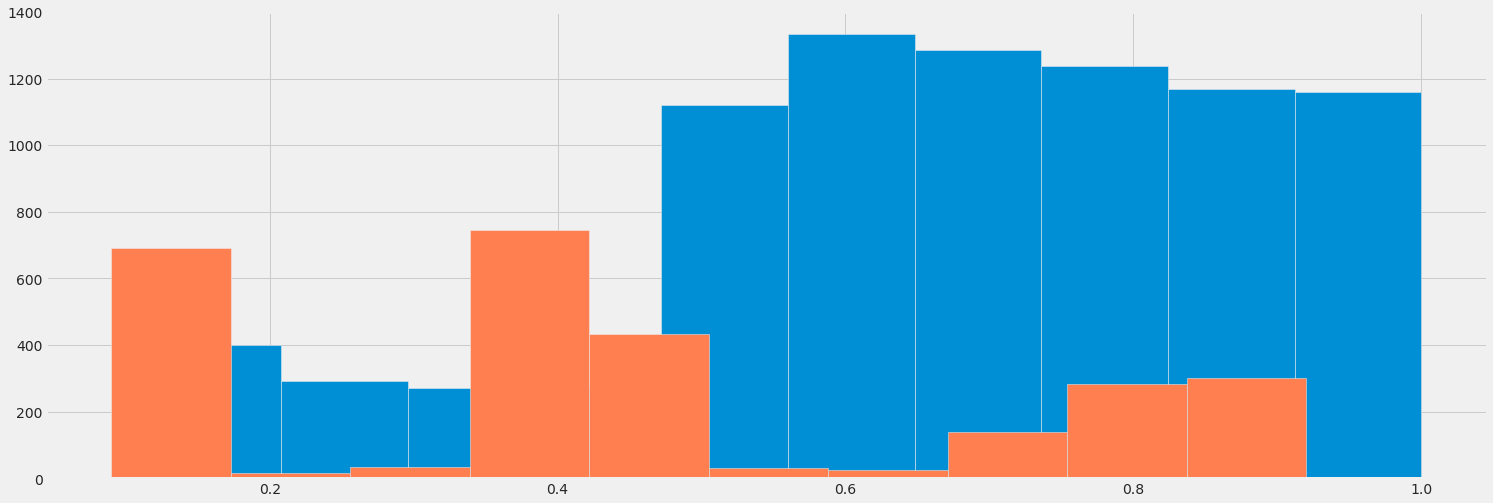

<bound method Series.mean of 0        0.82
1        0.75
2        0.54
3        0.60
4        0.85
         ... 
11243    0.54
11244    0.94
11246    0.67
11247    0.98
11248    0.75
Name: employee_satisfaction, Length: 8554, dtype: float64>
<bound method Series.mean of 7        0.42
8        0.09
11       0.54
17       0.10
18       0.44
         ... 
11214    0.11
11220    0.11
11226    0.11
11239    0.39
11245    0.73
Name: employee_satisfaction, Length: 2695, dtype: float64>


In [ ]:
df[df.attrit==0].employee_satisfaction.hist()
df[df.attrit==1].employee_satisfaction.hist(facecolor='coral')
plt.show()
print(df[df.attrit==0].employee_satisfaction.mean)
print(df[df.attrit==1].employee_satisfaction.mean)

## **Findings:**


*   I assume that the people who have higher workload will influence the attrition. However, according to the analysis, it doesn't mean the bigger workload, the more people will leave the company. Attrition are focus on the people are the level 2, 5 to 6 of workload.
*   Mean of employee satisfaction who stayed is 82% and employees who left is 42%. This is not so surprising finding as we expect more satisfied employees to stay with the company and less satisfied employees to quit.


## 1.3 Prepocessing and Exploratory Data Analysis 

In [ ]:
# Get unique departments
df['dept'].unique()

array(['SALES', 'HR', 'ADMIN', 'IS', 'TECH', 'PM', 'FIN', 'EXEC', 'MKT',
       'RTD'], dtype=object)

In [ ]:
# Get unique salaries
df['salary'].unique()

array(['MEDIUM', 'SMALL', 'LARGE'], dtype=object)

In [ ]:
# Transform the salary categorical to numeric so that it can be fit into model
le_salary = preprocessing.LabelEncoder()
df['salary'] = le_salary.fit_transform(df['salary'])

In [ ]:
# Get unique salary
df['salary'].unique()

array([1, 2, 0])

In [ ]:
# Transform the department categorical to numeric so that it can be fit into model
le_dept = preprocessing.LabelEncoder()
df['dept'] = le_dept.fit_transform(df['dept'])

In [ ]:
# Get unique department
df['dept'].unique()

array([8, 3, 0, 4, 9, 6, 2, 1, 5, 7])

In [ ]:
df.describe()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
count,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000
mean,0.612957,0.716225,3.799716,201.176727,3.499600,0.144991,0.239577,0.021869,5.476309,1.398791
std,0.248235,0.171378,1.232190,50.058105,1.469892,0.352107,0.426844,0.146261,3.254824,0.640545
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,3.000000,1.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000,7.000000,1.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,8.000000,2.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,9.000000,2.000000


In [ ]:
# Group by attrition and find the mean
df.groupby('attrit').mean()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years,dept,salary
attrit,,,,,,,,,
0,0.667108,0.715087,3.779635,198.999766,3.379238,0.175473,0.027473,5.447276,1.340659
1,0.441080,0.719837,3.863451,208.086456,3.881633,0.048237,0.004082,5.568460,1.583302


In [ ]:
# Group by attrition and get the count
df.groupby('attrit').count()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years,dept,salary
attrit,,,,,,,,,
0,8554,8554,8554,8554,8554,8554,8554,8554,8554
1,2695,2695,2695,2695,2695,2695,2695,2695,2695


## **Summary of data based on above table:**

*   About 11,249 employee observations and 10 features
*   Mean satisfaction of employees who stayed is 0.66%
*   The turnover rate is 31.5%. This is a surprisingly high number. According to  survey, the maximum voluntary turnover rate within any industry is about 20%.





In [ ]:
#Correlation Matrix
df.corr()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
employee_satisfaction,1.000000,0.102478,-0.145495,-0.019836,-0.096433,0.053876,-0.388659,0.021922,-0.003919,-0.054159
last_performance_rating,0.102478,1.000000,0.350931,0.345102,0.136279,-0.013131,0.011831,-0.000678,-0.017260,0.010850
workload,-0.145495,0.350931,1.000000,0.414586,0.196424,0.000341,0.029035,-0.006773,0.000601,0.003433
avg_montly_hours,-0.019836,0.345102,0.414586,1.000000,0.125143,-0.009111,0.077482,-0.006211,0.010709,0.010418
tenure_years,-0.096433,0.136279,0.196424,0.125143,1.000000,0.003290,0.145891,0.076958,-0.025400,-0.053842
ergo_issues,0.053876,-0.013131,0.000341,-0.009111,0.003290,1.000000,-0.154243,0.036826,-0.005885,-0.014359
attrit,-0.388659,0.011831,0.029035,0.077482,0.145891,-0.154243,1.000000,-0.068263,0.015892,0.161692
promo_in_last_5_years,0.021922,-0.000678,-0.006773,-0.006211,0.076958,0.036826,-0.068263,1.000000,-0.017400,-0.100687
dept,-0.003919,-0.017260,0.000601,0.010709,-0.025400,-0.005885,0.015892,-0.017400,1.000000,0.048241
salary,-0.054159,0.010850,0.003433,0.010418,-0.053842,-0.014359,0.161692,-0.100687,0.048241,1.000000


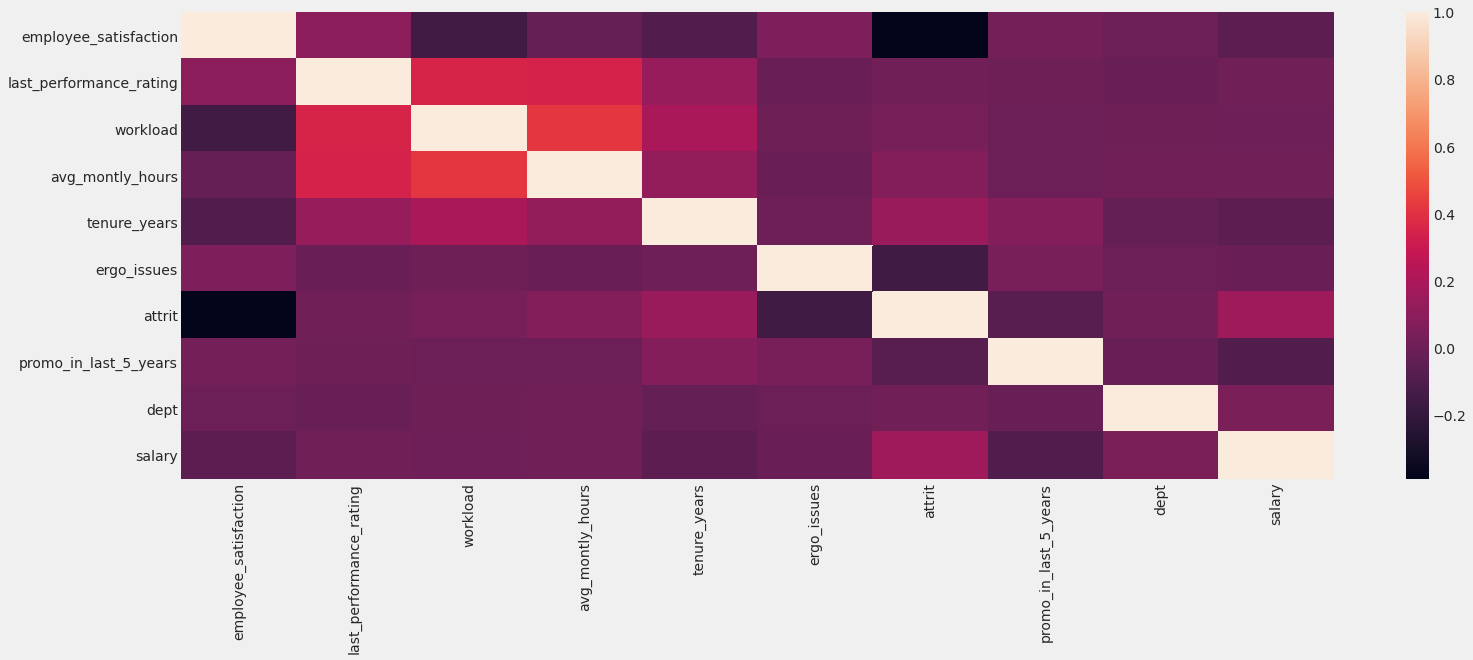

In [ ]:
# Create heatmap from correlation matrix
corr = df.corr()
corr = (corr)
sbn.heatmap(corr, 
            xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values)

## Positively Correlated Features:

*   last_performance_rating vs workload ：0.350931
*   last_performance_rating vs avg_montly_hours ：0.345102
*   workload vs	avg_montly_hours ：0.414586	
*   workload vs last_performance_rating ：0.350931	
*   avg_montly_hours vs last_performance_rating : 0.345102	
*   avg_montly_hours vs workload : 0.414586



Negatively Correlated Feature:
*   employee_satisfaction vs attrition: -0.388659


## Findings from correlation analysis

*   Most positively correlated feature with employee attrition is tenure years at the company(correlation coefficient: 0.145). This is somewhat expected in professional sector. After a couple of years in a company, employees want to explore new oppurtunities and challenges which may lead them to quit.
*   Most negatively correlated feature with employee attrition is satisfaction level(correlation coefficient: -0.38) and work accidents(correlation coefficient: -0.15). We have already discussed that satisfaction level is inversely correlated to attrition. One possible reason can be that work accident may lead to long paid leaves and employee may want to stay with the same company for related compensation and benefits.








Text(0.5, 1.0, 'Satisfaction Level of Employees')

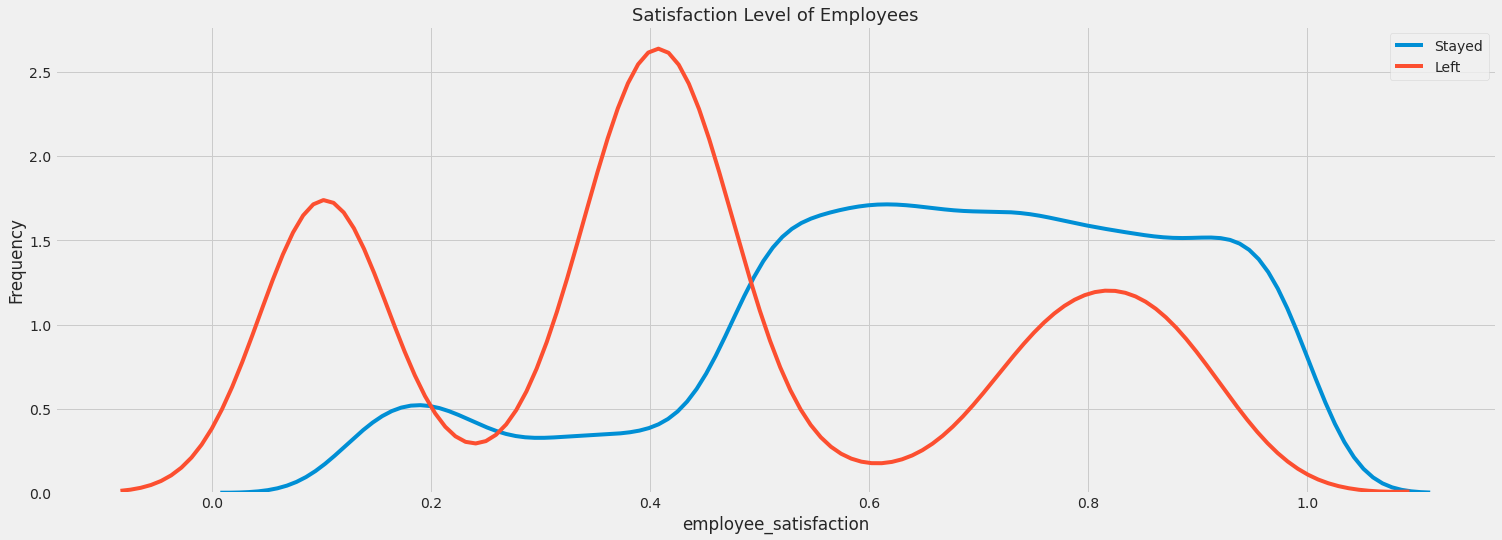

In [ ]:
# Plot satisfation level of employees
ax=sbn.kdeplot(df.loc[(df.attrit==0),'employee_satisfaction'],label="Stayed")
ax=sbn.kdeplot(df.loc[(df.attrit==1),'employee_satisfaction'],label="Left")
ax.set(xlabel='employee_satisfaction',ylabel="Frequency")
plt.title("Satisfaction Level of Employees",fontsize=18)

Text(0.5, 1.0, 'Promotion in last 5 years vs Attrition')

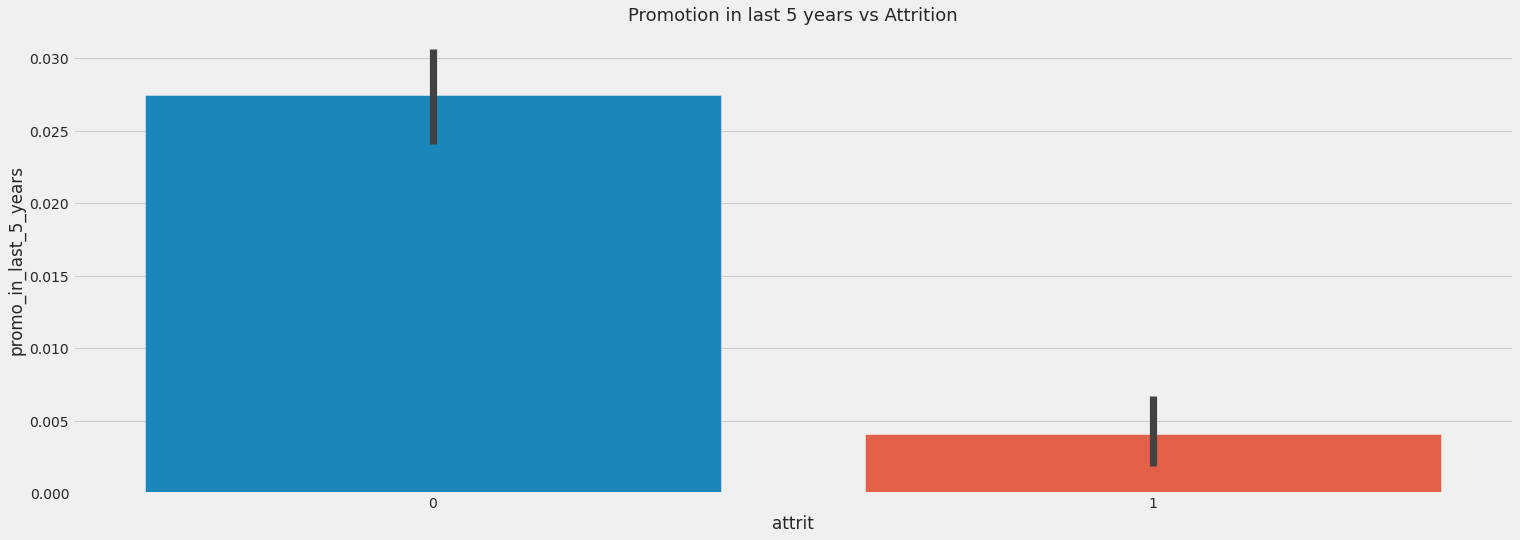

In [ ]:
# Plot attrition vs promotion
sbn.barplot(df.attrit, df.promo_in_last_5_years)
plt.title("Promotion in last 5 years vs Attrition",fontsize=18)

Text(0.5, 1.0, 'Tenure_years in company vs Attrition')

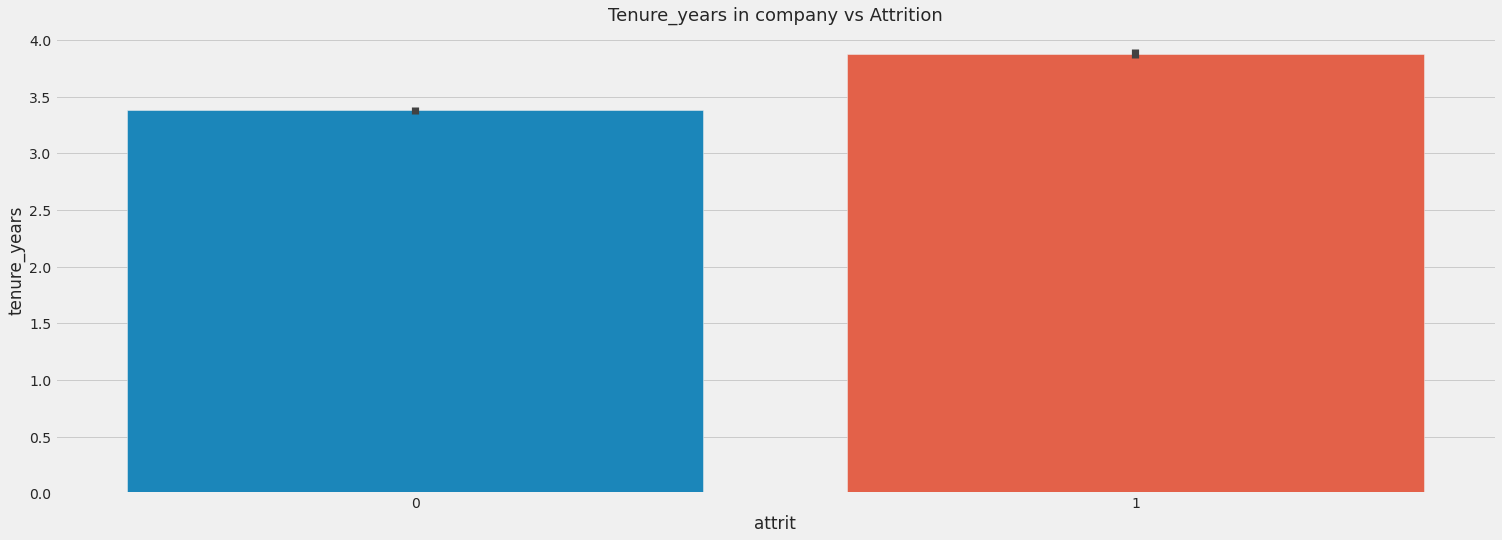

In [ ]:
# plot attrition vs tenure years in the company
sbn.barplot(df.attrit, df.tenure_years)
plt.title("Tenure_years in company vs Attrition",fontsize=18)

## 1.4 Use logistic regression to training the model

In [ ]:
# Assign values
X = df.drop('attrit', axis=1) 
Y = df.attrit

In [ ]:
# Train the model
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
# Apply logistic regression,Initialize Logistic Regressor 
model = LogisticRegression(max_iter=1200000, penalty = 'l1', solver = 'liblinear')

#Fit the model
fit = model.fit(X_train, y_train.values)

In [ ]:
# get features and weights
coeff = []
coeff = np.array(fit.coef_)
features = np.array(X.columns.values)
weights = np.vstack((features, coeff))

In [ ]:
# print weights of each feature
weights

array([['employee_satisfaction', 'last_performance_rating', 'workload',
        'avg_montly_hours', 'tenure_years', 'ergo_issues',
        'promo_in_last_5_years', 'dept', 'salary'],
       [-4.163422752506747, 0.7868886372482763, -0.3055275306827899,
        0.004302815662115413, 0.28073691352348557, -1.546208617352404,
        -1.567928950697831, 0.01478014576867495, 0.7629504759996144]],
      dtype=object)

In [ ]:
# 77.45% accuracy achieved
model.score(X_test,y_test)

0.7742222222222223

In [ ]:
#Get predictions for the test set.
#Each value corresponds to a attrition outcome of 0 (no) or 1 (yes)
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
# Find predicted probability from the fitted model
predict_proba = model.predict_proba(X_test)
predict_proba

array([[0.96069196, 0.03930804],
       [0.55874375, 0.44125625],
       [0.92006644, 0.07993356],
       ...,
       [0.59824952, 0.40175048],
       [0.82210927, 0.17789073],
       [0.27303296, 0.72696704]])

In [ ]:
pred = model.predict(X_test)
metrics.confusion_matrix(y_test, pred)

array([[2331,  194],
       [ 568,  282]])

In [ ]:
#sklearn.metrics.classification_report(y_true, y_pred)
print(metrics.classification_report(y_test, pred))
print(cross_val_score(LogisticRegression(max_iter=1200000), X, Y, scoring='accuracy'))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      2525
           1       0.59      0.33      0.43       850

    accuracy                           0.77      3375
   macro avg       0.70      0.63      0.64      3375
weighted avg       0.75      0.77      0.75      3375

[0.79422222 0.78977778 0.78533333 0.79066667 0.78301467]


## 1.4 Generate 5 sample predictions for input values


In [ ]:
d = {'employee_satisfaction':[0.95,0.7,0.67,0.98,0.77],'last_performance_rating':[0.81,0.81,0.65,0.92,0.65],'workload':[4,4,3,2,5],'avg_montly_hours':[151,124,289,210,192],'tenure_years':[5,4,2,2,3],'ergo_issues':[0,0,0,1,0],'promo_in_last_5_years':[0,0,0,0,1],'dept':[8,3,0,4,9],'salary':[1,2,0,0,1]}

In [ ]:
arbitrary_values = pd.DataFrame(data = d)
arbitrary_values.join(pd.DataFrame(model.predict(arbitrary_values), columns = {'Prediction'}).set_index([pd.Index(arbitrary_values.index)]))

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years,dept,salary,Prediction
0,0.95,0.81,4,151,5,0,0,8,1,0
1,0.70,0.81,4,124,4,0,0,3,2,0
2,0.67,0.65,3,289,2,0,0,0,0,0
3,0.98,0.92,2,210,2,1,0,4,0,0
4,0.77,0.65,5,192,3,0,1,9,1,0


## **Findings from logistics regression model :**


*   Employee_satisfaction is the most important factor which makes employees stay (regression coefficient is highest: -4.11). Employee_satisfaction has come up in all our findings above and this is definitely the most important factor to determine attrition.

*   Employees had ergo issues are more likely to stay (regression coefficient is high: -1.52). Maybe it is because if a person has a ergo issues, the company will pay some pay insurance to protect employees, as a result, the employees are willing to stay at the company.

*   Employees promoted in last 5 years are more likely to stay (regression coefficient is high: -1.34). This definitely makes sense that if an employee has not been promoted for 5 years, the employees career has plateaued out for some reason. Employer should make efforts to find the root cause of this stagnation.






## **Summary:**


1.   Using the above probability values, employees with >90% probability are highly likely to leave. Inline with the findings, employer should take steps to provide enrichment and support to help the employee stay are highly likely to leave. Inline with the findings, employer should take steps to provide enrichment and support to help the employee stay.

2.   Given the findings from statistical analysis and regression model, we can draw the four major implications.
 

*   If at any point the employees satisfaction takes a hit of >30% the employee is at a risk of leaving. This is a crucial datapoint for an employer to intervene.
*   Money is not the only thing which employees value.
*   If an employee has not been promoted in last 5 years, employer should dig deeper to find the root cause. There can be various reasons for an employee to be not promoted such as employee is in the wrong role, wrong team or does not have conducive team environment.


##Part 2 - Use logistic regression to predict when customers are going to transact.

### 2.1 Data Acquisition & Rudimentary Analysis#

In [ ]:
#Read data from Google Sheet
disney_df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQGojnTJ4xLYiAmWEHuwYhT79kHsumvuHFColzRN0yptVI5GRB7scHUgL_Kk77JtF6JNbO9mhKHcBk-/pub?output=csv')
print("Shape of dataframe is: {}".format(disney_df.shape))

Shape of dataframe is: (505, 16)


In [ ]:
disney_df.head()

,row,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
0,672,1,84000,0,1,0,1,0,0,0,1,0,1,1,0,0
1,671,1,124000,0,1,0,1,0,0,1,0,0,1,1,0,0
2,669,0,45000,0,0,0,0,0,0,1,1,0,1,1,0,0
3,668,0,35000,1,1,0,0,0,0,1,0,1,0,1,0,0
4,667,1,124000,0,1,1,0,1,0,1,0,0,1,1,0,0


In [ ]:
disney_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   row                                  505 non-null    int64
 1   transaction                          505 non-null    int64
 2   salary_usd                           505 non-null    int64
 3   is_male                              505 non-null    int64
 4   is_married                           505 non-null    int64
 5   is_college                           505 non-null    int64
 6   is_professional                      505 non-null    int64
 7   is_senior                            505 non-null    int64
 8   is_employed                          505 non-null    int64
 9   is_single_income                     505 non-null    int64
 10  children_present                     505 non-null    int64
 11  is_renter                            505 non-null    int64

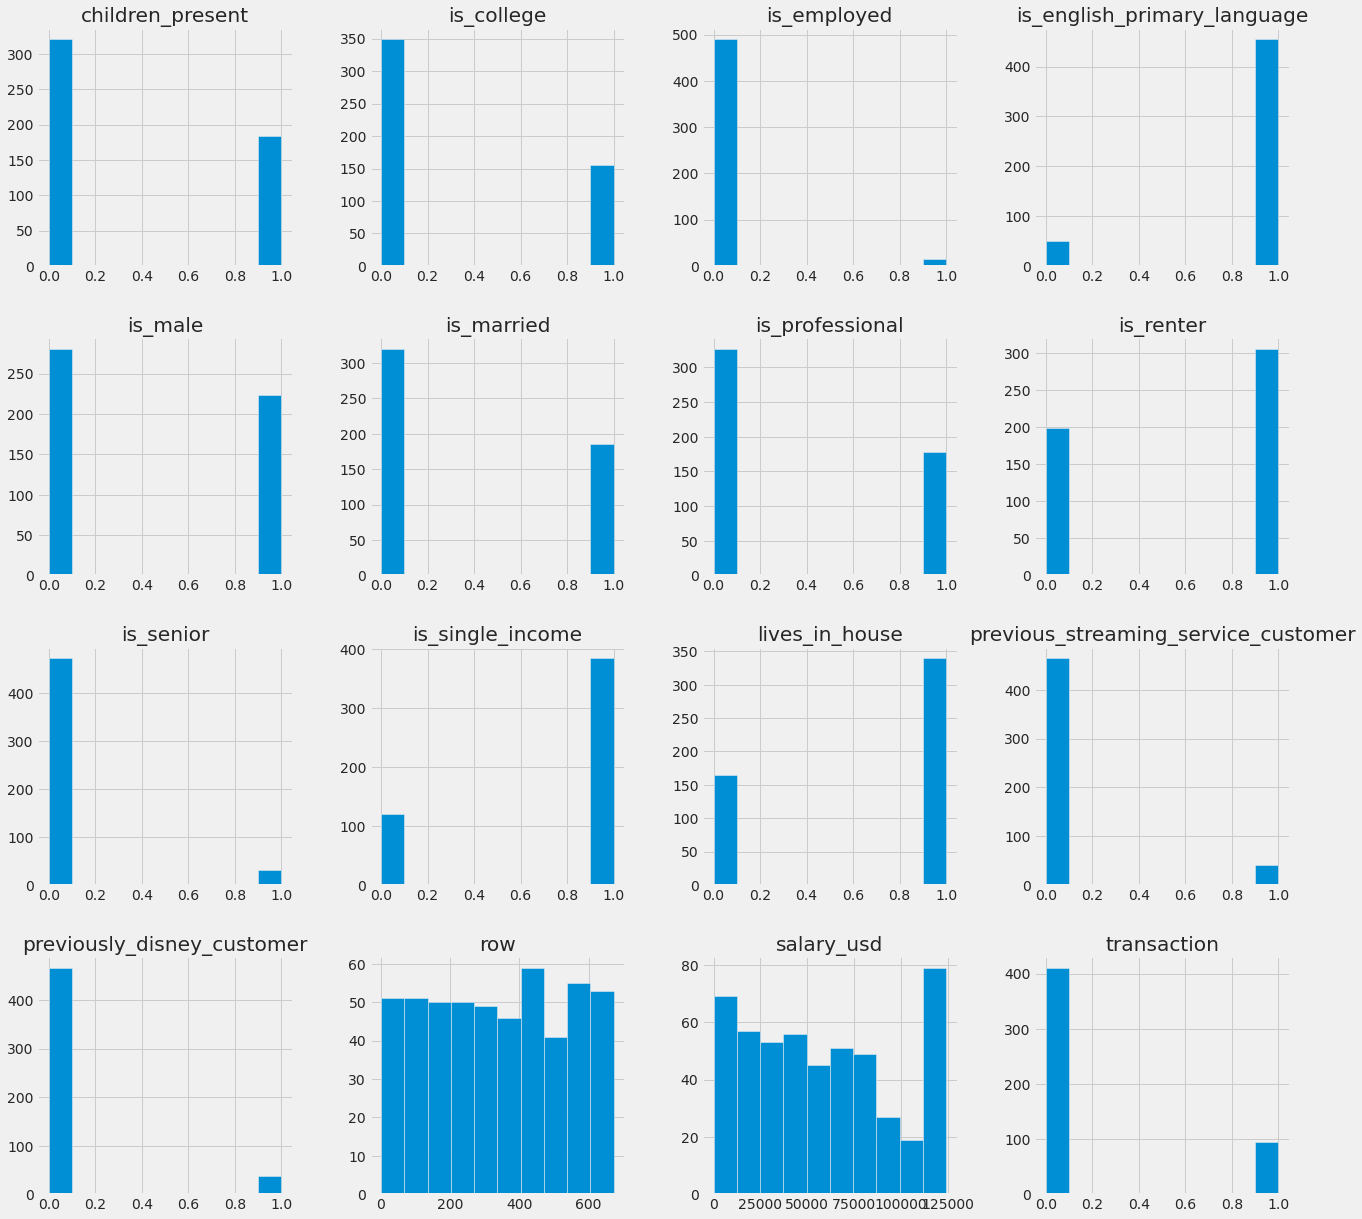

In [ ]:
disney_df.hist(figsize=(20,20))
plt.show()

In [ ]:
disney_df['transaction'].value_counts()

0    411
1     94
Name: transaction, dtype: int64

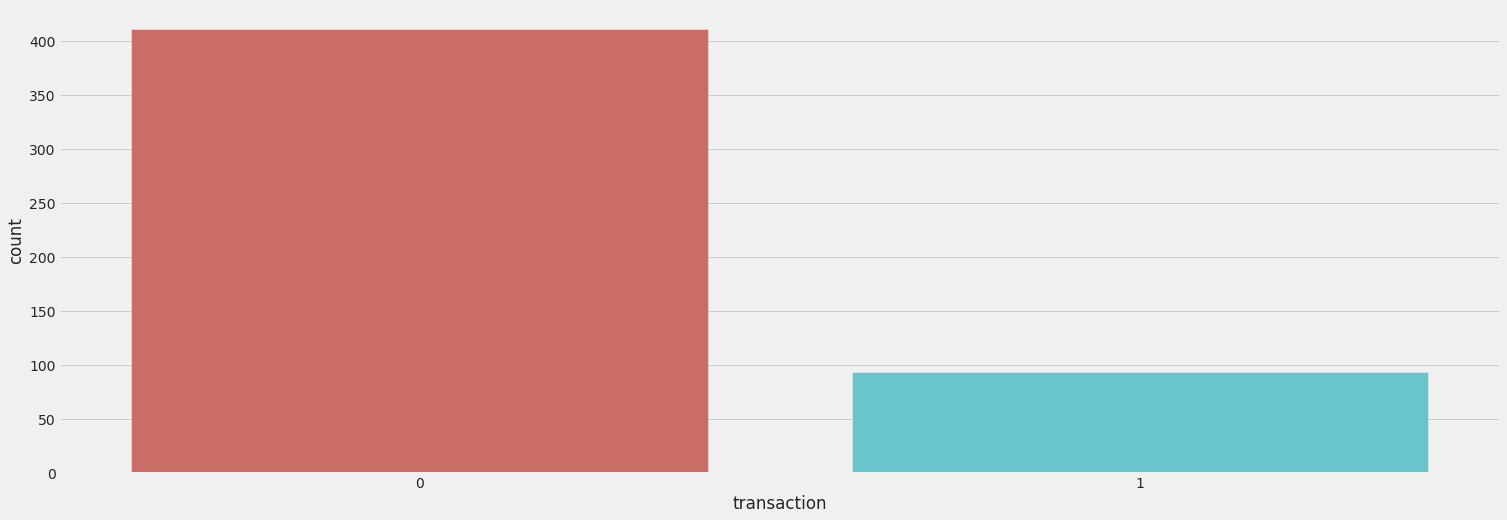

<Figure size 1656x576 with 0 Axes>

In [ ]:
sns.countplot(x='transaction',data=disney_df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [ ]:
#find the probabolity of transaction in each feature
select_features = disney_df.columns
for i in select_features:
  contingency_table = pd.crosstab(disney_df.transaction, disney_df[i])
  a = contingency_table.div(contingency_table.sum(1), axis = 0)
  display(a)

row,1,2,3,4,5,6,8,9,10,11,12,13,15,16,18,20,21,22,23,24,25,26,27,28,29,30,32,33,34,38,40,42,43,44,45,46,47,50,51,52,...,623,624,625,627,628,629,630,631,632,633,634,636,637,638,639,640,641,642,643,646,647,648,649,650,652,653,655,656,657,658,659,660,662,665,666,667,668,669,671,672
transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.002433,0.000000,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,0.000000,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,...,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.000000,0.000000,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.002433,0.002433,0.000000,0.002433,0.002433,0.000000,0.000000
1,0.000000,0.010638,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.010638,0.010638,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.010638,0.010638


transaction,0,1
transaction,,
0,1.0,0.0
1,0.0,1.0


salary_usd,0,2000,3000,5000,7000,8000,10000,12000,13000,15000,17000,18000,20000,21000,23000,25000,26000,28000,30000,31000,33000,35000,36000,38000,40000,41000,43000,45000,46000,48000,50000,51000,53000,55000,56000,58000,60000,61000,63000,64000,66000,68000,69000,71000,73000,74000,76000,78000,79000,81000,83000,84000,86000,88000,89000,91000,94000,96000,98000,99000,101000,102000,106000,107000,109000,111000,112000,114000,116000,119000,121000,124000
transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.014599,0.019465,0.036496,0.014599,0.029197,0.009732,0.021898,0.021898,0.029197,0.021898,0.029197,0.012165,0.021898,0.009732,0.014599,0.024331,0.004866,0.012165,0.017032,0.017032,0.014599,0.017032,0.021898,0.029197,0.026764,0.014599,0.019465,0.026764,0.017032,0.002433,0.019465,0.004866,0.012165,0.026764,0.012165,0.012165,0.009732,0.009732,0.019465,0.024331,0.017032,0.012165,0.014599,0.009732,0.014599,0.007299,0.017032,0.004866,0.019465,0.038929,0.014599,0.000000,0.007299,0.004866,0.014599,0.007299,0.002433,0.007299,0.002433,0.007299,0.009732,0.004866,0.000000,0.002433,0.000000,0.002433,0.002433,0.002433,0.007299,0.002433,0.000000,0.019465
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.010638,0.000000,0.010638,0.021277,0.031915,0.000000,0.010638,0.000000,0.000000,0.000000,0.010638,0.010638,0.021277,0.031915,0.010638,0.042553,0.000000,0.021277,0.010638,0.010638,0.031915,0.000000,0.063830,0.053191,0.010638,0.010638,0.553191


is_male,0,1
transaction,,
0,0.535280,0.464720
1,0.648936,0.351064


is_married,0,1
transaction,,
0,0.725061,0.274939
1,0.234043,0.765957


is_college,0,1
transaction,,
0,0.742092,0.257908
1,0.468085,0.531915


is_professional,0,1
transaction,,
0,0.705596,0.294404
1,0.393617,0.606383


is_senior,0,1
transaction,,
0,0.931873,0.068127
1,0.957447,0.042553


is_employed,0,1
transaction,,
0,0.963504,0.036496
1,1.000000,0.000000


is_single_income,0,1
transaction,,
0,0.170316,0.829684
1,0.531915,0.468085


children_present,0,1
transaction,,
0,0.63747,0.36253
1,0.62766,0.37234


is_renter,0,1
transaction,,
0,0.304136,0.695864
1,0.787234,0.212766


lives_in_house,0,1
transaction,,
0,0.374696,0.625304
1,0.117021,0.882979


is_english_primary_language,0,1
transaction,,
0,0.116788,0.883212
1,0.021277,0.978723


previously_disney_customer,0,1
transaction,,
0,0.944039,0.055961
1,0.840426,0.159574


previous_streaming_service_customer,0,1
transaction,,
0,0.931873,0.068127
1,0.872340,0.127660


In [ ]:
disney_df.groupby('transaction').mean()

,row,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
transaction,,,,,,,,,,,,,,,
0,338.253041,45625.304136,0.464720,0.274939,0.257908,0.294404,0.068127,0.036496,0.829684,0.36253,0.695864,0.625304,0.883212,0.055961,0.068127
1,333.808511,113308.510638,0.351064,0.765957,0.531915,0.606383,0.042553,0.000000,0.468085,0.37234,0.212766,0.882979,0.978723,0.159574,0.127660


Obeservations:

*   There are 411 no's and 94 yes's in the outcome variables.List item
*   The average salary of customers who made a transaction is higher than that of the customers who didn't

*   In target variable transaction, a status of "is not male", "is married", "is college", "is professional", "is not senior", "is not employe", "is not single income", "is not children present", "is not renter", "is lives in house", "is english primary language", "is not previously disney customer", and "is previous streaming service customer" is more likely to make a transaction than the opposite one.


In [ ]:
#Correlation Matrix
disney_df.corr()

,row,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
row,1.000000,-0.008820,0.009426,0.010479,0.004594,-0.041528,0.015073,-0.012003,-0.035410,0.058334,0.080179,0.000717,0.069129,0.048148,-0.017116,-0.029686
transaction,-0.008820,1.000000,0.674450,-0.089043,0.396663,0.230819,0.254171,-0.040857,-0.083674,-0.330667,0.007934,-0.384798,0.213833,0.124466,0.152880,0.085800
salary_usd,0.009426,0.674450,1.000000,0.028663,0.454105,0.336642,0.398918,0.030765,-0.157484,-0.338652,-0.108313,-0.496908,0.204394,0.114267,0.112717,0.090492
is_male,0.010479,-0.089043,0.028663,1.000000,-0.083220,0.058695,-0.016306,0.013186,0.031615,0.086415,-0.071359,0.100080,-0.040893,-0.077693,-0.043146,0.018558
is_married,0.004594,0.396663,0.454105,-0.083220,1.000000,0.123212,0.092844,0.089029,-0.084614,-0.637696,0.039234,-0.598008,0.249266,0.031881,0.032395,0.005274
is_college,-0.041528,0.230819,0.336642,0.058695,0.123212,1.000000,0.412782,0.002020,-0.091731,-0.170479,-0.203397,-0.136179,-0.119061,0.092488,-0.012000,0.089560
is_professional,0.015073,0.254171,0.398918,-0.016306,0.092844,0.412782,1.000000,-0.191902,-0.129087,-0.162660,-0.205463,-0.168439,-0.060462,0.133555,0.040947,-0.016868
is_senior,-0.012003,-0.040857,0.030765,0.013186,0.089029,0.002020,-0.191902,1.000000,-0.045508,0.145213,-0.163145,-0.206098,0.007893,0.086223,-0.043382,-0.016092
is_employed,-0.035410,-0.083674,-0.157484,0.031615,-0.084614,-0.091731,-0.129087,-0.045508,1.000000,0.070276,0.061433,0.045614,0.072146,-0.137266,-0.005691,-0.008125
is_single_income,0.058334,-0.330667,-0.338652,0.086415,-0.637696,-0.170479,-0.162660,0.145213,0.070276,1.000000,-0.012347,0.330502,-0.081418,-0.060457,-0.017113,-0.060210


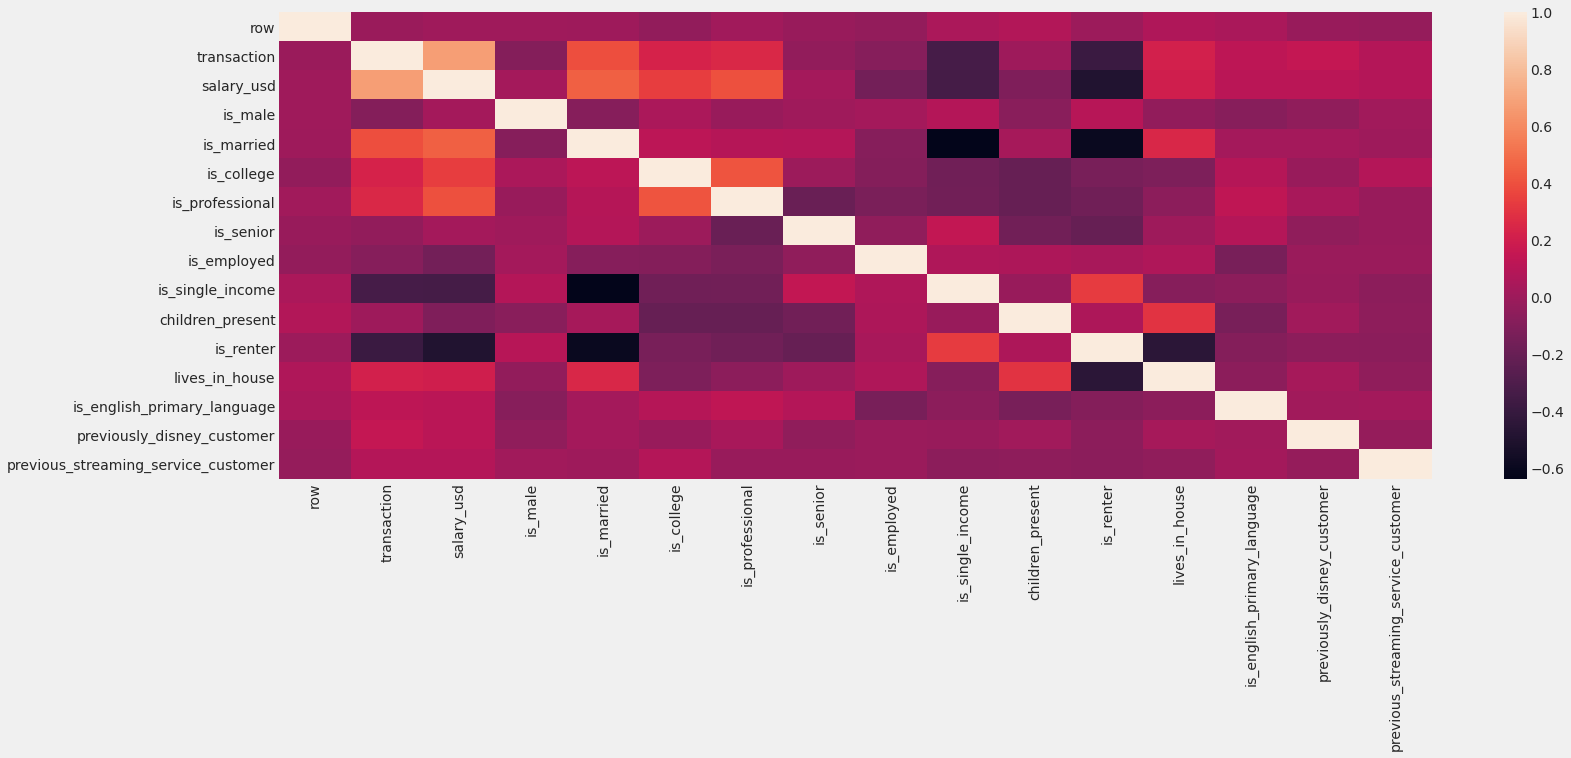

In [ ]:
#Visualizing data prior to processing
sns.heatmap(disney_df.corr())

## Positively Correlated Features:

*   transaction vs salary_usd ：0.674450, it is a highest relation with transaction
*   transaction vs is_married ：0.396663


## 2.2 Use RFE(Recursive Feature Elimination) Feature Selection method, GridSearch

In [ ]:
data_final_vars=disney_df.columns.values.tolist()
y1=['transaction']
X1=[j for j in data_final_vars if j not in y1]

In [ ]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 5)
rfe = rfe.fit(disney_df[X1], disney_df[y1] )
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False False False False False  True False  True False
  True False False]
[ 1  1  2  9  7  5  6  8  1  4  1  3  1 11 10]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# select training columns and testing columns
selected_colums = [c for c in disney_df.columns if c != "transaction"]
selected_target = ["transaction"]
train_data = disney_df[selected_colums]
target_data = disney_df[selected_target]


X_train_lgt, X_test_lgt ,y_train_lgt ,y_test_lgt = train_test_split(train_data, target_data, test_size=0.2, random_state=1)

# Using direct Normalization and Logistics Regression combining model

pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression(random_state=1, max_iter=10000))])
pipe_lr.fit(X_train_lgt,y_train_lgt)
score = pipe_lr.score(X_test_lgt,y_test_lgt)
print("Test Accuracy:{}".format(score))

Test Accuracy:0.900990099009901


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Using direct normalization and Logistics Regression combining model, and Grid Search 
pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression(random_state=0))])
param_range=[0.0001,0.001,0.01,0.1,1,10,100,1000]
param_penalty=['l1','l2']
param_grid=[{'clf__C':param_range,'clf__penalty':param_penalty}]
gs = GridSearchCV(estimator=pipe_lr,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train_lgt,y_train_lgt)
print(gs.best_score_)
print(gs.best_params_)

0.9209756097560977
{'clf__C': 10, 'clf__penalty': 'l2'}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Feature selection, uses RFE(Recursive Feature Elimination) method and tests on different subsets of features
scores = []
for i in range(1, len(disney_df[X1].columns) + 1):
  scaler = StandardScaler()
  rfe = RFE(LogisticRegression(), i)
  rfe.fit(scaler.fit_transform(disney_df[X1]), disney_df[y1] )
  selected_colums = disney_df[X1].columns[rfe.support_]
  #selected_colums = [c for c in disney_df.columns if c != "transaction"]
  selected_target = ["transaction"]
  train_data = disney_df[selected_colums]
  target_data = disney_df[selected_target]


  X_train_lgt, X_test_lgt ,y_train_lgt ,y_test_lgt = train_test_split(train_data, target_data, test_size=0.2, random_state=1)


  pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression(random_state=1, max_iter=10000))])
  pipe_lr.fit(X_train_lgt,y_train_lgt)
  score = pipe_lr.score(X_test_lgt,y_test_lgt)
  scores.append((score, i))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
for score in scores:
  print("{} features, score: {}".format(score[1], score[0]))

1 features, score: 0.9108910891089109
2 features, score: 0.9207920792079208
3 features, score: 0.9306930693069307
4 features, score: 0.9306930693069307
5 features, score: 0.9306930693069307
6 features, score: 0.9306930693069307
7 features, score: 0.9306930693069307
8 features, score: 0.9306930693069307
9 features, score: 0.9306930693069307
10 features, score: 0.9108910891089109
11 features, score: 0.9108910891089109
12 features, score: 0.900990099009901
13 features, score: 0.900990099009901
14 features, score: 0.900990099009901
15 features, score: 0.900990099009901


## 2. Generate 5 sample predictions for input values

In [ ]:
generate_df = {'row':[12,36,44,24,174],'transaction':[0,0,0,1,0],'salary_usd':[400000,34000,210000,150000,80000],'is_male':[1,1,0,1,1],'is_married':[0,0,0,1,1],'is_professional':[0,0,0,1,0],'is_senior':[0,0,0,0,1],'is_employed':[0,0,0,0,1],'is_single_income':[0,0,0,0,1],'children_present':[0,0,0,0,1],'is_rener':[0,0,0,0,1],'lives_in_house':[1,1,0,0,1],'is_english_primary_language':[1,1,0,0,1],'previously_disney_customer':[1,0,0,0,1],'previous_streaming_service_customer':[1,1,0,0,1]}

In [ ]:
arbitrary_values2 = pd.DataFrame(data = generate_df)
arbitrary_values2.join(pd.DataFrame(pipe_lr.predict(arbitrary_values2), columns = {'Prediction'}).set_index([pd.Index(arbitrary_values2.index)]))

,row,transaction,salary_usd,is_male,is_married,is_professional,is_senior,is_employed,is_single_income,children_present,is_rener,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer,Prediction
0,12,0,400000,1,0,0,0,0,0,0,0,1,1,1,1,0
1,36,0,34000,1,0,0,0,0,0,0,0,1,1,0,1,0
2,44,0,210000,0,0,0,0,0,0,0,0,0,0,0,0,0
3,24,1,150000,1,1,1,0,0,0,0,0,0,0,0,0,0
4,174,0,80000,1,1,0,1,1,1,1,1,1,1,1,1,0


# Part 3 - Use regularization to predict salaries for a sports player

## 3.1 Data Acquisition & Rudimentary Analysis

In [ ]:
import pandas as pd
#Read data from Google Sheet
bb_df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSGoxSrcq8KGsuqFqTv9iGOi8TkspixXiFL4sk6BJ_izi7Dzs8PEnoSE7fNeitJhNQwW7mXsNqeOO_K/pub?output=csv')
print("Shape of dataframe is: {}".format(bb_df.shape))

Shape of dataframe is: (243, 20)


In [ ]:
bb_df.head()

,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,League,Division,PutOuts,Assists,Errors,NewLeague
0,875000,457,101,14,42,63,22,17,6521,1767,281,1003,977,619,A,W,389,39,4,A
1,1300000,441,118,28,84,86,68,8,2723,750,126,433,420,309,A,E,190,2,2,A
2,940000,593,152,23,69,75,53,6,2765,686,133,369,384,321,A,W,315,10,6,A
3,70000,312,68,2,32,22,24,1,312,68,2,32,22,24,A,E,86,150,15,A
4,815000,526,146,13,71,70,84,6,2648,715,77,352,342,289,N,W,303,9,9,N


In [ ]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Salary                243 non-null    int64 
 1   count_at_bats         243 non-null    int64 
 2   count_hits            243 non-null    int64 
 3   count_home_runs       243 non-null    int64 
 4   count_runs            243 non-null    int64 
 5   RBI                   243 non-null    int64 
 6   count_walks           243 non-null    int64 
 7   years_experience      243 non-null    int64 
 8   cumulative_at_bats    243 non-null    int64 
 9   cumulative_hits       243 non-null    int64 
 10  cumulative_home_runs  243 non-null    int64 
 11  cumulative_runs       243 non-null    int64 
 12  cumulative_RBI        243 non-null    int64 
 13  cumulative_walks      243 non-null    int64 
 14  League                243 non-null    object
 15  Division              243 non-null    ob

In [ ]:
bb_df.describe()

,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,PutOuts,Assists,Errors
count,2.430000e+02,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,3.964856e+05,377.621399,99.975309,10.666667,50.123457,47.362140,38.115226,7.473251,2654.497942,717.703704,71.831276,362.061728,332.069959,263.711934,284.263374,102.781893,7.629630
std,4.205241e+05,151.221516,45.997478,8.449656,25.186109,25.642821,21.239171,5.018386,2344.518332,657.431235,88.616130,337.841166,333.997166,277.955388,275.126756,134.263086,6.244557
min,0.000000e+00,16.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000e+04,255.500000,64.000000,4.000000,31.000000,29.000000,22.000000,4.000000,826.500000,209.500000,14.000000,100.500000,91.500000,66.500000,113.500000,6.500000,3.000000
50%,2.500000e+05,360.000000,95.000000,8.000000,48.000000,44.000000,34.000000,6.000000,1931.000000,510.000000,39.000000,258.000000,230.000000,174.000000,211.000000,33.000000,6.000000
75%,6.665000e+05,511.000000,136.000000,16.000000,68.500000,63.500000,52.000000,11.000000,3890.500000,1037.500000,93.000000,523.500000,424.500000,329.500000,322.500000,151.500000,10.000000
max,1.975000e+06,687.000000,238.000000,40.000000,117.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000


In [ ]:
# Drop some rows if salary equals to 0
bb_df = bb_df.drop(bb_df[bb_df.Salary == 0].index)

In [ ]:
# Convert non-numeric columns to numeric columns

le = LabelEncoder()

for column in bb_df.columns:
  if not pd.api.types.is_numeric_dtype(bb_df[column]):
    bb_df[column] = le.fit_transform(bb_df[column])
display(bb_df)

,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,League,Division,PutOuts,Assists,Errors,NewLeague
0,875000,457,101,14,42,63,22,17,6521,1767,281,1003,977,619,0,1,389,39,4,0
1,1300000,441,118,28,84,86,68,8,2723,750,126,433,420,309,0,0,190,2,2,0
2,940000,593,152,23,69,75,53,6,2765,686,133,369,384,321,0,1,315,10,6,0
3,70000,312,68,2,32,22,24,1,312,68,2,32,22,24,0,0,86,150,15,0
4,815000,526,146,13,71,70,84,6,2648,715,77,352,342,289,1,1,303,9,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,517000,574,159,21,107,75,59,10,4631,1300,90,702,504,488,0,0,238,445,22,0
180,250000,257,66,5,31,26,32,14,3910,979,33,518,324,382,1,1,87,166,14,0
181,300000,204,49,6,23,25,12,7,1309,308,27,126,132,66,0,1,419,46,5,0
182,700000,283,77,14,45,47,26,16,6840,1910,259,915,1067,546,0,1,144,6,5,0


## 3.2 Splitting the data for training


In [ ]:
X_bb = bb_df[[x for x in bb_df.columns if x != 'Salary']]
y_bb = bb_df['Salary']
X_bb_train, X_bb_test, y_bb_train, y_bb_test = train_test_split(X_bb, y_bb,test_size = 0.3, random_state=1)

## 3.3 Use Linear Regression

In [ ]:
# build a linear regression model
linreg = LinearRegression()
linreg.fit(X_bb_train, y_bb_train)
y_bb_linear_pred = linreg.predict(X_bb_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

print ("Intercept: ",linreg.intercept_)
print ("Co-efficient: ",linreg.coef_)

#Borrow from: https://medium.com/@harishreddyp98/regularization-in-python-699cfbad8622

Intercept:  -19473.08557459875
Co-efficient:  [  -1334.71994582    7066.28866084   10594.31732315   -4062.00793543
   -2346.78342034    8669.8119759    27037.51346706    -349.22894258
     459.38581886   -2003.89655222    1199.02269322    1589.64219671
    -897.82041509  157223.45508899 -126123.85802726     195.57938953
     362.93286803   -6836.72431818 -110544.02221516]


In [ ]:
# Calculate R^2 value, MAE, MSE, RMSE
print("R-Square Value",r2_score(y_bb_test,y_bb_linear_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_bb_test, y_bb_linear_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_bb_test, y_bb_linear_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_bb_test, y_bb_linear_pred)))

R-Square Value 0.34784428906428466


mean_absolute_error : 231087.51139864273


mean_squared_error :  89497771924.00388


root_mean_squared_error :  299161.78219151567


## 3.4 Use Lasso regression to minimizes overfitting

In [ ]:
# try alpha=100 and exmaine coefficient

lassoreg = Lasso(alpha=100, normalize=True)
lassoreg.fit(X_bb_train, y_bb_train)
print(lassoreg.coef_)
print("\n")
print(pd.Series(lassoreg.coef_, index=X_bb_train.columns))
y_bb_lasso_pred = lassoreg.predict(X_bb_test)


# Calculate R^2 value, MAE, MSE, RMSE
print("R-Square Value",r2_score(y_bb_test,y_bb_lasso_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_bb_test, y_bb_lasso_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_bb_test, y_bb_lasso_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_bb_test, y_bb_lasso_pred)))

[  -1533.09560314    6527.68138651    5263.75859144   -1738.55171184
    -696.25220854    7958.177424     12412.4024363     -151.79997106
     376.62126346    -600.10830134     480.21797452     853.85548178
    -749.17732888  129356.76629195 -128966.16391055     216.63894888
     286.69514623   -6466.38647944  -89111.71383691]


count_at_bats            -1533.095603
count_hits                6527.681387
count_home_runs           5263.758591
count_runs               -1738.551712
RBI                       -696.252209
count_walks               7958.177424
years_experience         12412.402436
cumulative_at_bats        -151.799971
cumulative_hits            376.621263
cumulative_home_runs      -600.108301
cumulative_runs            480.217975
cumulative_RBI             853.855482
cumulative_walks          -749.177329
League                  129356.766292
Division               -128966.163911
PutOuts                    216.638949
Assists                    286.695146
Errors                 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7762925095.375, tolerance: 2265066299.21875
  positive)


## 3.5 LassoCV: lasso regression with built-in cross-validation of the alpha parameter

In [ ]:
# Select the best alpha with LassoCV
lassoregcv = LassoCV()
lassoregcv.fit(X_bb_train, y_bb_train)
y_bb_lasso_cv_pred = lassoregcv.predict(X_bb_test)
print('alpha : ',lassoregcv.alpha_)
print("\n")

# Examine the coefficients
print(pd.Series(lassoregcv.coef_, index=X_bb_train.columns))
print("\n")

# Calculate R^2 value, MAE, MSE, RMSE
print("R-Square Value",r2_score(y_bb_test,y_bb_lasso_cv_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_bb_test, y_bb_lasso_cv_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_bb_test, y_bb_lasso_cv_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_bb_test, y_bb_lasso_cv_pred)))

alpha :  528558.377746582


count_at_bats             -0.000000
count_hits              1947.983455
count_home_runs            0.000000
count_runs                 0.000000
RBI                        0.000000
count_walks             3216.974128
years_experience           0.000000
cumulative_at_bats      -350.778947
cumulative_hits         1202.484496
cumulative_home_runs      -0.000000
cumulative_runs            0.000000
cumulative_RBI           730.219252
cumulative_walks        -104.547688
League                     0.000000
Division                  -0.000000
PutOuts                  186.967227
Assists                   -0.000000
Errors                    -0.000000
NewLeague                 -0.000000
dtype: float64


R-Square Value 0.45056116829275283


mean_absolute_error : 196620.85833178114


mean_squared_error :  75401549693.97104


root_mean_squared_error :  274593.4261667075


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13734931442.38086, tolerance: 2265066299.21875
  positive)


## Obeservation:
###  Regularization is a method for constraining or regularizing the size of the coefficientsIn this part, we focus on regularization using Lasso Regression and Lasso Regression with built-in cross-validation of the alpha parameter.

1.   In linear regression model, the R square equals to 0.3478, with using Lasso Regression, some features coefficient shrink, and R square increases. 
2.    In Lasso Regression and Lasso Regression with built-in cross-validation of the alpha parameter model, which is a way to find best alpha, the best alpha value is 502582.  In this situation, some features coefficients shrink to zero, thus remove them from model to fit the model better. The R square increases to 0.48. If alpha is getting bigger, some irrelevant features will be reomove, and features coefficient shrink to zero.



## 3.6 Use Ridge Regression with built-in cross-validation of the alpha parameter

In [ ]:
# select the best alpha with RidgeCV

ridgeregcv = RidgeCV()
ridgeregcv.fit(X_bb_train, y_bb_train)
y_bb_ridge_cv_pred = ridgeregcv.predict(X_bb_test)
print('alpha : ',ridgeregcv.alpha_)
print(pd.Series(ridgeregcv.coef_, index=X_bb_train.columns))
print("\n")


# Calculate R^2 value, MAE, MSE, RMSE
print("R-Square Value",r2_score(y_bb_test,y_bb_ridge_cv_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_bb_test, y_bb_ridge_cv_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_bb_test, y_bb_ridge_cv_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_bb_test, y_bb_ridge_cv_pred)))


alpha :  1.0
count_at_bats            -1350.500927
count_hits                7077.131662
count_home_runs          10939.884982
count_runs               -3912.720785
RBI                      -2511.176611
count_walks               8616.186419
years_experience         26949.417187
cumulative_at_bats        -343.429282
cumulative_hits            422.625719
cumulative_home_runs     -2085.786846
cumulative_runs           1226.095312
cumulative_RBI            1620.205592
cumulative_walks          -900.953869
League                  129847.441519
Division               -121814.889503
PutOuts                    194.643554
Assists                    351.572384
Errors                   -6507.339296
NewLeague               -83545.937817
dtype: float64


R-Square Value 0.35427611199111275


mean_absolute_error : 228586.96543568978


mean_squared_error :  88615108762.87796


root_mean_squared_error :  297682.89968165447


## 3.7 Use Elasticnet regression

In [ ]:
#use Elasticnet regression
#l1_ratio = 0 equeals laaso(L1) regression
elastic_net = ElasticNet(alpha=1000, l1_ratio=0.5)
elastic_net.fit(X_bb_train, y_bb_train)
elastic_net_predict = elastic_net.predict(X_bb_test)

# calculate R^2 value, MAE, MSE, RMSE

print("R-Square Value",r2_score(y_bb_test,elastic_net_predict))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_bb_test, elastic_net_predict))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_bb_test, elastic_net_predict))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_bb_test, elastic_net_predict)))

R-Square Value 0.4592669472855877


mean_absolute_error : 194555.42338473405


mean_squared_error :  74206823021.0978


root_mean_squared_error :  272409.2931988514


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4365885537373.3735, tolerance: 2265066299.21875
  positive)


Reference:

1.Regularization in Python
https://medium.com/@harishreddyp98/regularization-in-python-699cfbad8622

2.A Simple Example of Pipeline in Machine Learning with Scikit-learn
https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

3.Ridge and Lasso Regression: L1 and L2 Regularization
https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b